In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def get_data_split(data_df, selected_columns, target_label):
    df_processed = data_df[selected_columns].reset_index(drop=True)
    input_feat = list(set(selected_columns).difference({target_label}))

    df_x = df_processed[input_feat].reset_index(drop=True)
    df_y = df_processed[target_label]

    transfer = MinMaxScaler(feature_range=(0, 1))

    # normalization
    df_x = transfer.fit_transform(df_x)

    return train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [2]:
import pandas as pd
import numpy as np

sun_data_df = pd.read_csv('dataset_processed.csv')

df_with_location_en = pd.get_dummies(sun_data_df, columns=['Location'], drop_first=True)
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

# Only data between 10 a.m. and 3 p.m. is available
# excluding periods when no power generation will occur
min_hour_of_interest = 10
max_hour_of_interest = 15

df_with_loc_season_en['delta_hr'] = df_with_loc_season_en.Hour - min_hour_of_interest

# There is a perfect correlation between the cosine of the date characteristic and its actual value (month and hour)
df_with_loc_season_en['sine_mon'] = np.sin((df_with_loc_season_en.Month - 1) * np.pi / 11)
df_with_loc_season_en['cos_mon'] = np.cos((df_with_loc_season_en.Month - 1) * np.pi / 11)

df_with_loc_season_en['sine_hr'] = np.sin(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr'] = np.cos(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))

selected_columns = ['Latitude', 'Humidity', 'Temp', 'power_class', 'Wind',
                    'Visibility', 'Pressure', 'Cloud', 'Location_Grissom',
                    'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                    'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                    'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                    'Location_USAFA', 'Season_Spring', 'Season_Summer', 'Season_Winter',
                    'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

x_train, x_test, y_train, y_test = get_data_split(df_with_loc_season_en, selected_columns, 'power_class')

print(len(x_train), len(x_test))

16836 4209


In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB()
gnb.fit(x_train, y_train)

print("accuracy:", gnb.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(gnb.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(gnb.predict(x_test), y_test, average='weighted'))

accuracy: 0.4378712283202661
train f1_score: 0.45986367318141497
test f1_score: 0.45190464742593156


Text(0.5, 1.0, 'scores at different n_components')

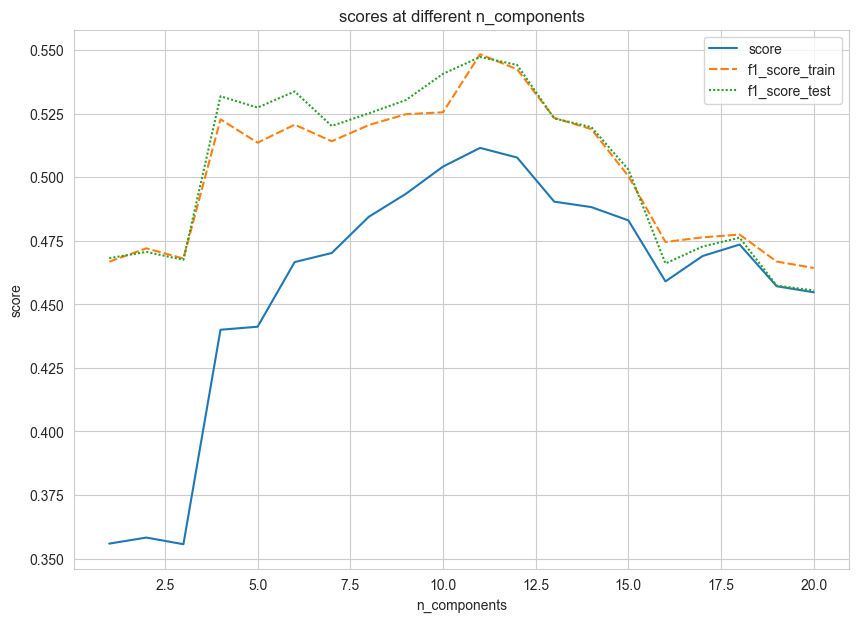

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca_score = np.zeros(20)
f1_score_test = np.zeros(20)
f1_score_train = np.zeros(20)

for i in range(1, 21):
    j = i - 1
    pca = PCA(n_components=i, random_state=24)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    gnb = GaussianNB()
    gnb.fit(x_train_pca, y_train)

    pca_score[j] = gnb.score(x_test_pca, y_test)

    f1_score_train[j] = metrics.f1_score(gnb.predict(x_train_pca), y_train, average='weighted')
    f1_score_test[j] = metrics.f1_score(gnb.predict(x_test_pca), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": pca_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=range(1, 21))
sns.lineplot(data=data)
plt.xlabel("n_components")
plt.ylabel("score")
plt.title("scores at different n_components")

In [5]:
# n_components=11

pca = PCA(n_components=11, random_state=24)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

gnb = GaussianNB()
gnb.fit(x_train_pca, y_train)

print("accuracy:", gnb.score(x_test_pca, y_test))

print("train f1_score:", metrics.f1_score(gnb.predict(x_train_pca), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(gnb.predict(x_test_pca), y_test, average='weighted'))

accuracy: 0.5115229270610596
train f1_score: 0.5483553920490281
test f1_score: 0.5472818474887481
